In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import LeakyReLU


%matplotlib inline
sess = tf.InteractiveSession()


Using TensorFlow backend.


# MSE function example

In [2]:
vec_1 = tf.placeholder(tf.float64)
vec_2 = tf.placeholder(tf.float64)
mse = tf.reduce_mean((vec_1 - vec_2)**2)

def compute_mse(el_1, el_2):
    return sess.run(mse, feed_dict={vec_1: el_1, vec_2: el_2})                

In [3]:
for n in [1,5,10,10**3]:    
    elems = [np.arange(n),np.arange(n,0,-1), np.zeros(n),
             np.ones(n),np.random.random(n),np.random.randint(100,size=n)]
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el, el_2))
            my_mse = compute_mse(el, el_2)
            if not np.allclose(true_mse,my_mse):
                print ('Wrong result:')
                print ('mse(%s,%s)'%(el,el_2))
                print ("should be: %f, but your function returned %f"%(true_mse,my_mse))
                raise ValueError("Ð§ÑÐ¾-ÑÐ¾ Ð½Ðµ ÑÐ°Ðº")

print ("All tests passed")


All tests passed


# Logistic regression 

In [4]:
X, y = load_digits(2, return_X_y=True)

y_onehot = OneHotEncoder().fit_transform(y[:, None]).toarray()

print ("y [shape - %s]:"%(str(y_onehot.shape)),y_onehot[:10])
print ("X [shape - %s]:"%(str(X.shape)))

y [shape - (360, 2)]: [[ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]]
X [shape - (360, 64)]:


In [5]:
weights = tf.Variable(tf.random_normal((64, 2), stddev=0.1))
biases = tf.Variable(tf.zeros((2)))
input_X = tf.placeholder(tf.float32, shape=(None, 64))
input_y = tf.placeholder(tf.float32, shape=(None, 2))

logits = tf.matmul(input_X, weights) + biases
probs = tf.nn.softmax(logits)
loss = tf.losses.sigmoid_cross_entropy(input_y, logits)
opt = tf.train.GradientDescentOptimizer(0.09).minimize(loss)

In [6]:
def train_function(X, y):
    sess.run(tf.global_variables_initializer())
    _, cur_loss = sess.run([opt, loss], feed_dict={input_X: X, input_y: y})
    return cur_loss


def predict_function(X):
    return sess.run(probs, feed_dict={input_X: X})

loss at iter 0: 0.9962
train auc: 0.757997907604
test auc: 0.756158873806
loss at iter 1: 0.4277
train auc: 0.905319090358
test auc: 0.8895173454
loss at iter 2: 1.2714
train auc: 0.910935521172
test auc: 0.930115635998
loss at iter 3: 2.5220
train auc: 0.999339243434
test auc: 1.0
loss at iter 4: 1.6386
train auc: 0.997494631353
test auc: 1.0
resulting weights:


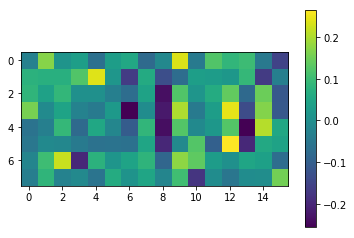

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, random_state=0)

for i in range(5):
    loss_i = train_function(X_train, y_train)
    print ("loss at iter %i: %.4f"%(i, loss_i))
    print ("train auc:",roc_auc_score(y_train,predict_function(X_train)))
    print ("test auc:",roc_auc_score(y_test,predict_function(X_test)))

    
print ("resulting weights:")
plt.imshow(weights.eval().reshape(8,-1))
plt.colorbar();

# MNIST dataset classification

In [21]:
img_rows, img_cols = 28, 28
nb_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False)

test_datagen = ImageDataGenerator(featurewise_center=True,
                                  featurewise_std_normalization=True)

train_datagen.fit(X_train)
test_datagen.fit(X_test)

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Two types of data augmenation, as a regularization method, are used - shifts and zooms (no need to use roatations as all images are orientated in the same way). Here are some examples of produced images.

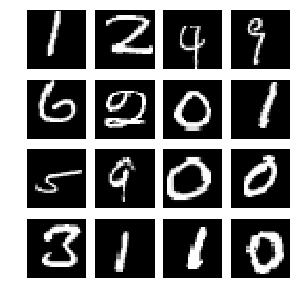

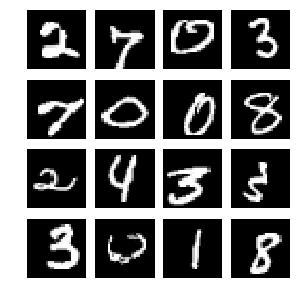

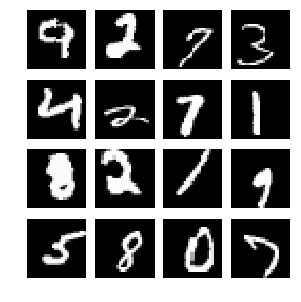

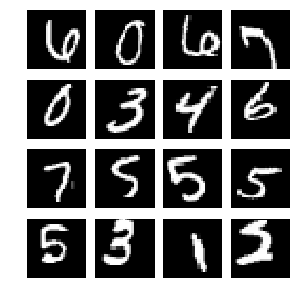

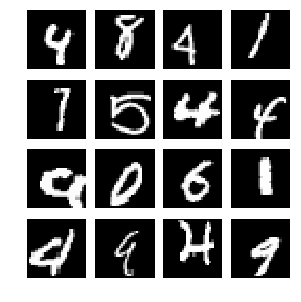

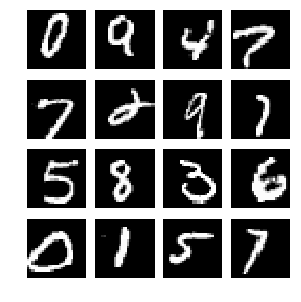

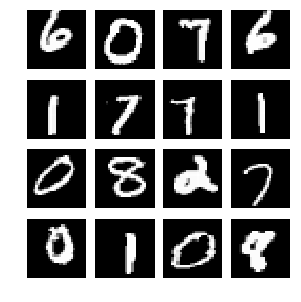

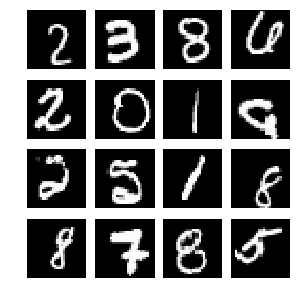

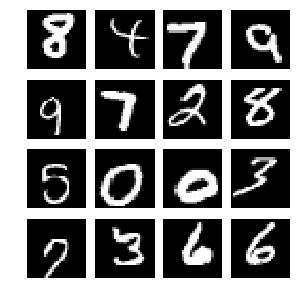

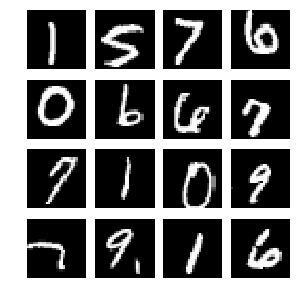

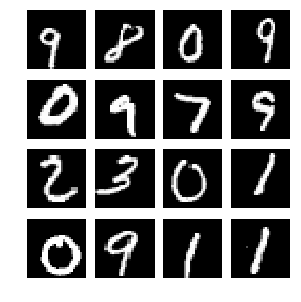

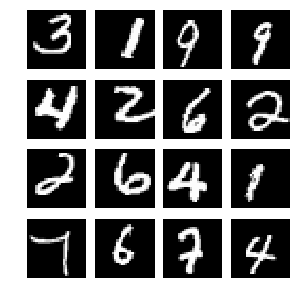

In [58]:
for fig_i, (x_b, y_b) in enumerate(train_datagen.flow(X_train, y_train, batch_size=16)):
    for i in range(0, 16):
        plt.subplot(4,4, 1 + i)
        plt.imshow(x_b[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
        plt.axis('off')
    plt.tight_layout(pad=0, h_pad=-1, w_pad=-15.0)
    plt.show()
    if fig_i > 10:
        break
    

In [78]:
batch_size = 256
nb_epoch = 1000

img_rows, img_cols = 28, 28
nb_filters_1 = 32
nb_filters_2 = 64
nb_filters_3 = 128
pool_size = (2, 2)
kernel_size = (3, 3)

In [98]:
from keras.layers.normalization import BatchNormalization


model = Sequential()

model.add(Convolution2D(nb_filters_1, kernel_size[0], kernel_size[1],
                        border_mode='valid',
                        input_shape=input_shape))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Convolution2D(nb_filters_2, kernel_size[0], kernel_size[1]))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Convolution2D(nb_filters_3, kernel_size[0], kernel_size[1]))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

for i in range(nb_epoch):
    model.fit_generator(train_datagen.flow(X_train, Y_train), 60000,
                        nb_epoch=1, verbose=0, 
                        nb_val_samples = len(Y_test))
    train_loss, train_acc = model.evaluate_generator(train_datagen.flow(X_train, Y_train), 20000)
    print(f"Epoch {i}")
    print("Train loss = %.3f; Train acc = %.4f" % (train_loss, train_acc))



Epoch 0
Train loss = 0.130; Train acc = 0.9587
Epoch 1
Train loss = 0.093; Train acc = 0.9707
Epoch 2
Train loss = 0.084; Train acc = 0.9747
Epoch 3
Train loss = 0.071; Train acc = 0.9769
Epoch 4
Train loss = 0.059; Train acc = 0.9805
Epoch 5
Train loss = 0.047; Train acc = 0.9847
Epoch 6
Train loss = 0.049; Train acc = 0.9858
Epoch 7
Train loss = 0.048; Train acc = 0.9853
Epoch 8
Train loss = 0.046; Train acc = 0.9850
Epoch 9
Train loss = 0.037; Train acc = 0.9888
Epoch 10
Train loss = 0.045; Train acc = 0.9860
Epoch 11
Train loss = 0.037; Train acc = 0.9873
Epoch 12
Train loss = 0.034; Train acc = 0.9895
Epoch 13
Train loss = 0.035; Train acc = 0.9893
Epoch 14
Train loss = 0.031; Train acc = 0.9908
Epoch 15
Train loss = 0.038; Train acc = 0.9885
Epoch 16
Train loss = 0.038; Train acc = 0.9883
Epoch 17
Train loss = 0.029; Train acc = 0.9912
Epoch 18
Train loss = 0.030; Train acc = 0.9908
Epoch 19
Train loss = 0.029; Train acc = 0.9906
Epoch 20
Train loss = 0.027; Train acc = 0.9912
Ep

KeyboardInterrupt: 

In [99]:
test_loss, test_acc = model.evaluate_generator(
    test_datagen.flow(X_test, Y_test, shuffle=False, batch_size=100), len(Y_test))
print('Test score:', test_loss)
print('Test accuracy:', test_acc)

Test score: 0.0185308977299
Test accuracy: 0.994600003362


The final test set accuracy is 99.46%. The only architecture was tested: several convolutional layers followed by pooling and a couple of dense layers.
Summary of used methods:

* Number of convolution layers: 2 are enough to get 99.2%, with 4 layers I got slightly less score
* Activations: I tested ReLU and Leaky ReLU, the former worked a bit better
* Dropout and batch normalization: these two methods did not work together well, so I only inserted batchnorm layers before activations and used dropout only before final layer to additionally produce better features